# Modeling of the hailers' trip duration and ride request interarrival time
  
[Importing libraries and loading data](#Import-neccessary-libraries-and-data)
    
[EDA, data cleaning and feature engineering](#EDA,-data-cleaning-and-feature-engineering)

[CDF of trip duration and request interarrival time](#CDF-of-trip-duration-and-request-interarrival-time)

[Fitting results with Phase-type distribution](#Fitting-results-with-Phase-type-distribution)

Data source:
- [NYC Gov TLC](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page)
- [May 2019 Yellow cab dataset](https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2019-05.csv)
- [May 2018 Yellow cab dataset](https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2018-05.csv)
    
    

## Import neccessary libraries and data

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
df2019 = pd.read_csv('yellow_tripdata_2019-05.csv', parse_dates=['tpep_pickup_datetime','tpep_dropoff_datetime'])
df2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7565261 entries, 0 to 7565260
Data columns (total 18 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        int64         
 4   trip_distance          float64       
 5   RatecodeID             int64         
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
dtypes: datetime64[ns](2), 

## EDA, data cleaning and feature engineering
[NYC TLC law on driver's fatique management](https://www1.nyc.gov/site/tlc/about/fatigued-driving-prevention-frequently-asked-questions.page)

In [2]:
timedf2019 = df2019[['tpep_pickup_datetime','tpep_dropoff_datetime']]

#Data cleaning: dropping results that don't belong to this dataset, which is recorded in the month of May
timedf2019 = timedf2019[(timedf2019.tpep_pickup_datetime>='2019-05-01')&(timedf2019.tpep_pickup_datetime<'2019-06-01')]

timedf2019.sort_values('tpep_pickup_datetime',inplace = True)
timedf2019.reset_index(drop= True,inplace = True)

#Assuming hailers' characteristics are the same for the same weekday within the month of May
timedf2019['pickup_week_day'] = timedf2019.tpep_pickup_datetime.dt.strftime('%w')
timedf2019['pickup_hour'] = timedf2019.tpep_pickup_datetime.dt.strftime('%H')

#Feature engineering:
timedf2019['trip_duration_seconds'] = (timedf2019.tpep_dropoff_datetime- timedf2019.tpep_pickup_datetime)/ np.timedelta64(1, 's')
#A trip duration must be larger than 1 second and cannot be longer than 10 hours due to NYC law
timedf2019 = timedf2019[(timedf2019.trip_duration_seconds>1) \
                &(timedf2019.trip_duration_seconds <=10*3600)]
timedf2019.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,pickup_week_day,pickup_hour,trip_duration_seconds
0,2019-05-01 00:00:00,2019-05-01 00:04:52,3,00,292.0
1,2019-05-01 00:00:01,2019-05-01 00:04:05,3,00,244.0
2,2019-05-01 00:00:01,2019-05-01 00:11:03,3,00,662.0
3,2019-05-01 00:00:02,2019-05-01 00:36:27,3,00,2185.0
4,2019-05-01 00:00:02,2019-05-01 00:18:53,3,00,1131.0


In [3]:
#On micro second time scale, hailers' request should come to the system one at a time
#However, tpep_pickup_datetime is chopped from microseconds values during data record
#e.g. 00:00:00.301 -> 00:00:00 and 00:00:00.999 -> 00:00:00
#Thus, we now add a discrete uniform random variables as "details" to the pickup time
timedf2019['microseconds'] = np.random.randint(1,999999,timedf2019.shape[0])
timedf2019['adjusted_pickup_time'] = timedf2019.tpep_pickup_datetime + timedf2019.microseconds*np.timedelta64(1,'us')
timedf2019.sort_values('adjusted_pickup_time',inplace = True)
timedf2019.reset_index(drop= True,inplace = True)
timedf2019['interarrival_time'] = (timedf2019['adjusted_pickup_time'] - timedf2019['adjusted_pickup_time'].shift())/np.timedelta64(1,'s')
timedf2019.head()


,tpep_pickup_datetime,tpep_dropoff_datetime,pickup_week_day,pickup_hour,trip_duration_seconds,microseconds,adjusted_pickup_time,interarrival_time
0,2019-05-01 00:00:00,2019-05-01 00:04:52,3,00,292.0,377145,2019-05-01 00:00:00.377145,NaN
1,2019-05-01 00:00:01,2019-05-01 00:04:05,3,00,244.0,171840,2019-05-01 00:00:01.171840,0.794695
2,2019-05-01 00:00:01,2019-05-01 00:11:03,3,00,662.0,354802,2019-05-01 00:00:01.354802,0.182962
3,2019-05-01 00:00:02,2019-05-01 00:18:53,3,00,1131.0,703800,2019-05-01 00:00:02.703800,1.348998
4,2019-05-01 00:00:02,2019-05-01 00:36:27,3,00,2185.0,747509,2019-05-01 00:00:02.747509,0.043709


In [8]:
#Extract Monday morning data
mondayMorningdf = timedf2019[(timedf2019.pickup_week_day == '1') \
    &(timedf2019.pickup_hour.astype('int')>=6)\
        &(timedf2019.pickup_hour.astype('int')<=10)]

mondayMorningdf.head()

#Output csv data for fitting

#mondayMorningdf.trip_duration_seconds.to_csv('MondayMorningMayTripDuration.csv',index = False,header=False)
#mondayMorningdf.interarrival_time.to_csv('MondayMorningMayInterarrivalTime.csv',index = False,header=False)

,tpep_pickup_datetime,tpep_dropoff_datetime,pickup_week_day,pickup_hour,trip_duration_seconds,microseconds,adjusted_pickup_time,interarrival_time
1330949,2019-05-06 06:00:00,2019-05-06 06:09:19,1,06,559.0,386485,2019-05-06 06:00:00.386485,0.977036
1330950,2019-05-06 06:00:02,2019-05-06 06:06:26,1,06,384.0,363185,2019-05-06 06:00:02.363185,1.976700
1330951,2019-05-06 06:00:03,2019-05-06 06:05:26,1,06,323.0,37288,2019-05-06 06:00:03.037288,0.674103
1330952,2019-05-06 06:00:04,2019-05-06 06:06:18,1,06,374.0,480266,2019-05-06 06:00:04.480266,1.442978
1330953,2019-05-06 06:00:06,2019-05-06 06:07:14,1,06,428.0,59895,2019-05-06 06:00:06.059895,1.579629


## CDF of trip duration and request interarrival time

881.6718800351139
619155.6278646506


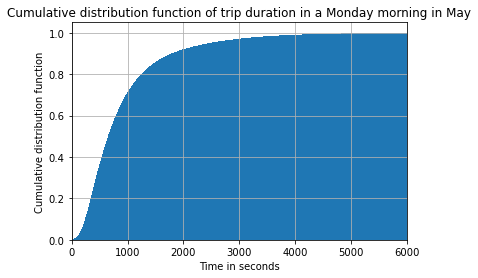

In [13]:
import matplotlib.pyplot as plt
mondayMorningdf.trip_duration_seconds.hist(cumulative=True, density=1, bins=10000)
print(mondayMorningdf.trip_duration_seconds.mean())
print(mondayMorningdf.trip_duration_seconds.var())
plt.xlim((0, 6000))
plt.xlabel('Time in seconds')
plt.ylabel('Cumulative distribution function')
plt.title('Cumulative distribution function of trip duration in a Monday morning in May')
plt.show()

0.40004989574189365
0.3119346207306654


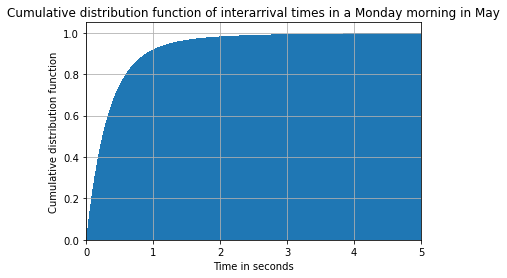

In [14]:
mondayMorningdf.interarrival_time.hist(cumulative=True, density=1, bins=10000)
print(mondayMorningdf.interarrival_time.mean())
print(mondayMorningdf.interarrival_time.var())
plt.xlim((0, 5))
plt.xlabel('Time in seconds')
plt.ylabel('Cumulative distribution function')
plt.title('Cumulative distribution function of interarrival times in a Monday morning in May')
plt.show()

## Fitting results with Phase-type distribution

- Why Phasetype distribution?
- [Hyperstar](https://www.mi.fu-berlin.de/inf/groups/ag-tech/projects/HyperStar/index.html) tool
- Screenshots of fitting process:
![Monday_morning_fitting_hailers_request_interarrival_time_screenshot.png](https://github.com/ChinhTranKaizen/RoboTaxiComputing/blob/main/May_2019/Monday_morning_fitting_hailers_request_interarrival_time_screenshot.png)
![Monday_morning_fitting_trip_duration_screenshot.png](https://github.com/ChinhTranKaizen/RoboTaxiComputing/blob/main/May_2019/Monday_morning_fitting_trip_duration_screenshot.png)
- Phase-type distribution parameters:
    - Interarrival time
        - Parameters of hyper-Erlang distribution:
        - number of different Erlang branches, m = 2

        - number of phases of i-th Erlang branch, i = 1,...,m
            - 1
            - 1

        - lambda values of i-th Erlang branch, i = 1,...,m
            - 1.7267731084677636
            - 4.498205141953858

        - initial probabilities of i-th Erlang branch, i = 1,...,m
            - 0.4910770837731824
            - 0.5089229162268176
    - Trip duration
        - Parameters of hyper-Erlang distribution:
        - number of different Erlang branches, m = 3

        - number of phases of i-th Erlang branch, i = 1,...,m
            - 2
            - 2
            - 3

        - lambda values of i-th Erlang branch, i = 1,...,m
            - 0.001389760104636313
            - 0.003209521473579796
            - 0.005006138252621861

        - initial probabilities of i-th Erlang branch, i = 1,...,m
            - 0.3294145100174458
            - 0.33373706843865636
            - 0.3368484215438979

Using the parameters plot it using python
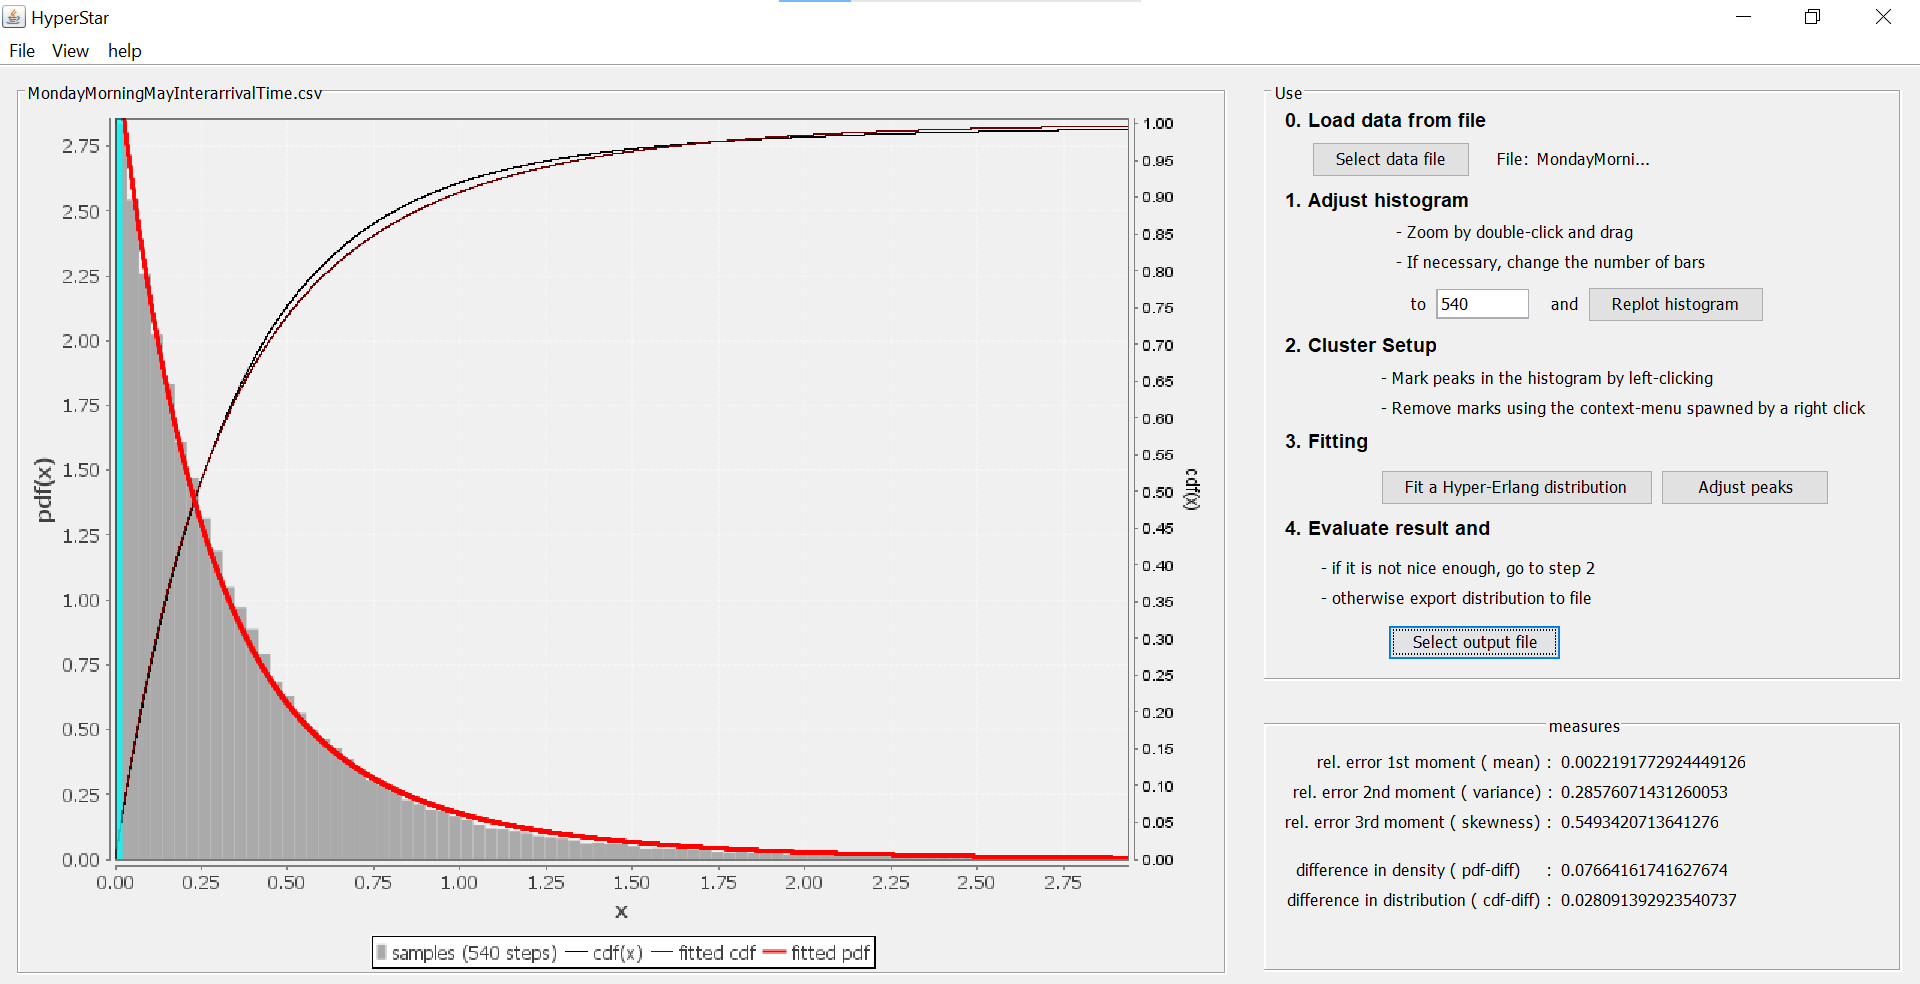
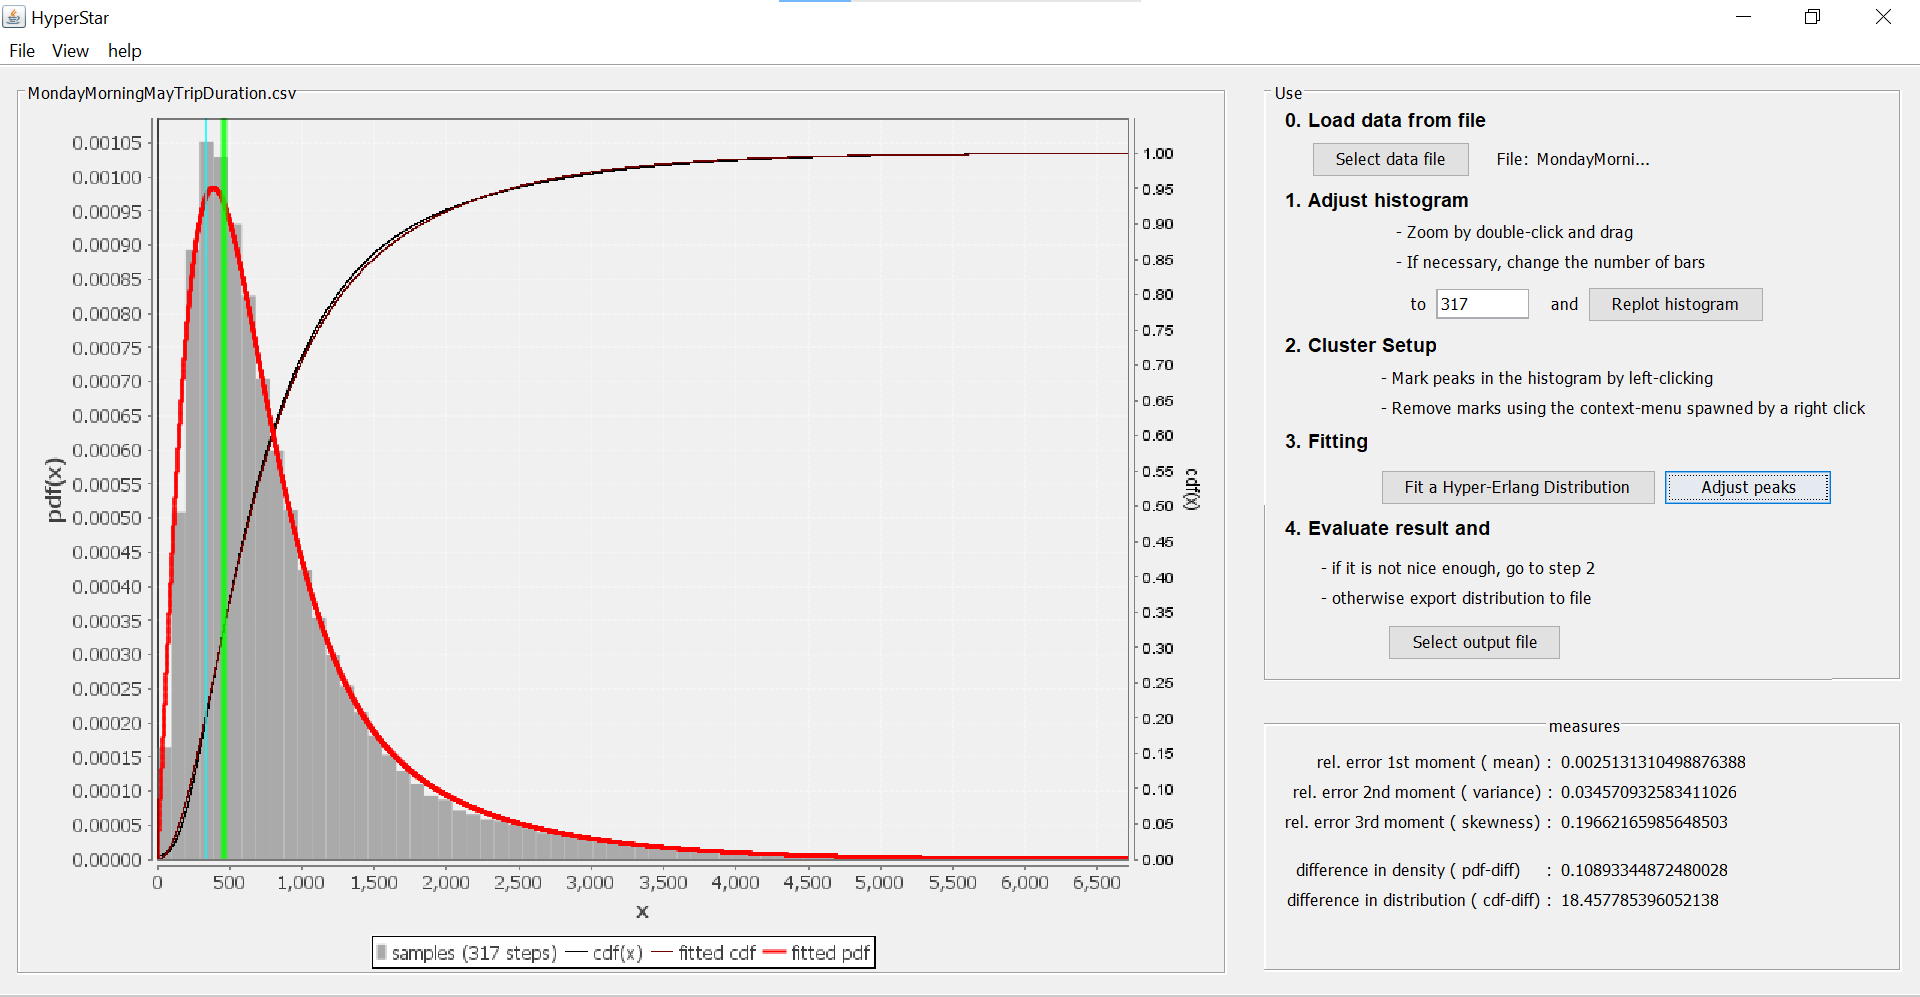